# Colin's Untappd Data - Type Analysis

## Introduction to data

The very first step of every data analysis is to take a precursory look at what the data is. Simply put, this section tells us how many data points this user has and what features are included. For the Untappd user data, we have info about the beer (name, style, type, ABV, IBU), user feedback (comments, rating), location information for both the brewery and venue and time data.

This dataset is all the Untappd data from one user, Colin Dixon. Check-ins span July, 2013 to present day. There are 2,166 unique check-ins. Each check-in has potentially 26 distinct attributes. Probably one of the most notable attribute is the user's rating of the check-in. Of the original 2,166 total check-ins, 2,152 have a user rating. The user's rating average is 4.10 with a standard deviation of 0.47.

Initial observation of the user rating's histogram revealed an odd bimodal peak. Upon further investigation I discovered that in April, 2015, the Untappd rating system changed from 0.5 increments to 0.25 increments. The change lends to an inconsistency in the data. Consequently, I filtered the data to only include check-ins after April, 2015. The resulting dataset's user ratings consist of 1490 data points normally distributed with mean 4.18 and standard deviation 0.38.

Unless otherwise specified, all further analysis is performed on the filtered data to increase reliability of the data set.

In [1]:
#Ignore deprecated warning buried in 3rd party packages
#(comment initially to look at warning and suppress warnings later)
import warnings
warnings.filterwarnings('ignore')

#Import all libraries needed
import pandas as pd #dataframe organization
import matplotlib.pyplot as plt #plotting
import matplotlib.gridspec as gridspec #plotting
from datetime import datetime, timedelta, date
import numpy as np
import util
import seaborn as sns
from scipy.stats import f as f
from scipy import stats


In [2]:
#Load the data and take a peek

#Import data into a pandas df

untappd_all = pd.read_csv("../data/user1.csv", encoding = "ISO-8859-1")

print('Looking at the first few rows: ')
untappd_all.head()

Looking at the first few rows: 


,beer_name,brewery_name,beer_type,beer_abv,beer_ibu,comment,venue_name,venue_city,venue_state,venue_country,...,brewery_url,brewery_country,brewery_city,brewery_state,flavor_profiles,purchase_venue,serving_type,checkin_id,bid,brewery_id
0,Chocolate Sombrero,Clown Shoes,Stout - American Imperial / Double,9.0,6,NaN,NaN,NaN,NaN,NaN,...,https://untappd.com/brewery/7583,United States,Ipswich,MA,NaN,NaN,NaN,38028941,126867,7583
1,Funky Galaxy,Prairie Artisan Ales,Saison / Farmhouse Ale,8.0,0,Very hoppy for a farmhouse ale. Still drinkabl...,NaN,NaN,NaN,NaN,...,https://untappd.com/brewery/37713,United States,Krebs,OK,NaN,NaN,NaN,38029429,325858,37713
2,Mesquite Smoked Porter,Ranger Creek Brewing & Distilling,Smoked Beer,6.4,20,"Delicious, very richly smoked strong porter.",NaN,NaN,NaN,NaN,...,https://untappd.com/brewery/2922,United States,San Antonio,TX,NaN,NaN,NaN,38053052,13677,2922
3,Hefeweizen,Widmer Brothers Brewing,Hefeweizen,4.9,30,"Drinkable, but nothing remotely special.",NaN,NaN,NaN,NaN,...,https://untappd.com/brewery/3028,United States,Portland,OR,NaN,NaN,NaN,38262335,6395,3028
4,Matt,Hair of the Dog Brewing Company,Strong Ale - American,11.5,0,"Simple put, this is as good as it gets when it...",NaN,NaN,NaN,NaN,...,https://untappd.com/brewery/622,United States,Portland,OR,NaN,NaN,NaN,38368018,12670,622


In [3]:
#Note some important points about the data (number of points, available features, etc)

print('Looking at some high level of the data')
print('Total number of entries: ', untappd_all.shape[0])
print('Total number of raw attributes: ',  untappd_all.shape[1])

print('')
print('More Info: ')
print('')
print(untappd_all.info())


Looking at some high level of the data
Total number of entries:  2166
Total number of raw attributes:  26

More Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2166 entries, 0 to 2165
Data columns (total 26 columns):
beer_name          2166 non-null object
brewery_name       2166 non-null object
beer_type          2166 non-null object
beer_abv           2166 non-null float64
beer_ibu           2166 non-null int64
comment            1463 non-null object
venue_name         1450 non-null object
venue_city         1191 non-null object
venue_state        1443 non-null object
venue_country      1450 non-null object
venue_lat          1450 non-null float64
venue_lng          1450 non-null float64
rating_score       2152 non-null float64
created_at         2166 non-null object
checkin_url        2166 non-null object
beer_url           2166 non-null object
brewery_url        2166 non-null object
brewery_country    2166 non-null object
brewery_city       2153 non-null object
brewery_st

In [4]:
#Data cleaning - removing the duplicate check-ins
#Assuming the file stays in chronological order, calculate each pair of times checked in and if close, check names
rows_to_delete = []
for index, row in untappd_all.iterrows():
    if index >0:
        datetime_curr = datetime.fromisoformat(row['created_at'])
        datetime_prev = datetime.fromisoformat(untappd_all.iloc[index-1]['created_at'])
        #Check if the time difference is less than an hour
        diff_timedelta = datetime_curr - datetime_prev
        if diff_timedelta < timedelta(hours=1):
            #Now check that one of the names doesn't completely include another of the names
            #(e.g., "Gingerbread Stout" and "Gingerbread Stout (2017)")
            if row['beer_name'] in untappd_all.iloc[index-1]['beer_name'] and row['bid'] != untappd_all.iloc[index-1]['bid']:
                rows_to_delete.append(index)
            if untappd_all.iloc[index-1]['beer_name'] in row['beer_name'] and untappd_all.iloc[index-1]['bid'] != row['bid']:
                rows_to_delete.append(index-1)
#Drop the rows
untappd_all.drop(index=rows_to_delete, inplace=True)   

In [5]:
#Create a new dataframe containing just unique beer info (for later)
labels, uniques = pd.factorize(untappd_all['bid'])
bid_columns = ['beer_name', 'beer_type', 'beer_abv', 'beer_ibu', 'beer_url', 'brewery_id', 'bid']
bid_df = pd.DataFrame(untappd_all.loc[untappd_all['bid'] == uniques[i], bid_columns].iloc[0] for i in range(uniques.size))

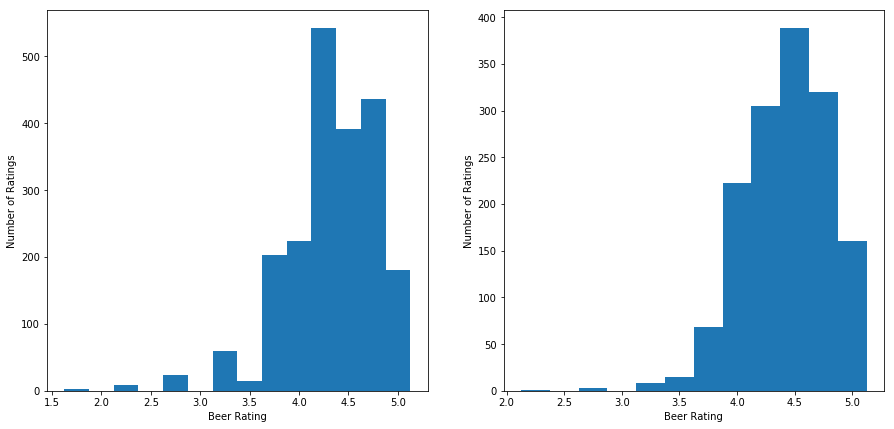

In [6]:
#Look at global ratings data

scoring_increment = 0.25

plt.figure(1, figsize=(15, 7))
plt.subplot(121)
plt.hist(untappd_all['rating_score'], bins=np.arange(untappd_all['rating_score'].min(), untappd_all['rating_score'].max()+scoring_increment, 0.25), align='right')
plt.xlabel('Beer Rating')
plt.ylabel('Number of Ratings')

#Filter for after 0.25 increments were introduced
untappd_all['created_at'] = untappd_all['created_at'].astype('datetime64[ns]')
date_changed = datetime.fromisoformat("2015-04-27 19:00:00")
untappd_ratingssyschanged = untappd_all.loc[untappd_all['created_at'] > date_changed]

plt.subplot(122)
plt.hist(untappd_ratingssyschanged['rating_score'], bins=np.arange(untappd_ratingssyschanged['rating_score'].min(), untappd_ratingssyschanged['rating_score'].max()+scoring_increment, 0.25), align='right')
plt.xlabel('Beer Rating')
plt.ylabel('Number of Ratings')


plt.show()

In [7]:
untappd_all['rating_score'].describe()

count    2087.000000
mean        4.085649
std         0.474987
min         1.500000
25%         3.750000
50%         4.000000
75%         4.500000
max         5.000000
Name: rating_score, dtype: float64

In [8]:
untappd_ratingssyschanged['rating_score'].describe()

count    1490.000000
mean        4.179698
std         0.379723
min         2.000000
25%         4.000000
50%         4.250000
75%         4.500000
max         5.000000
Name: rating_score, dtype: float64

## Does Colin have a type?

This analysis investigates the frequency and preferences of beer style. Does Colin prefer his beer blonde or dark? Stout or pale? Sour?!?!? The list goes on and on.



Can we break it down a little further though? For example, Independence Brewing Co. Convict Hill is categorized as "Stout - Oatmeal", while Jester King Brewery's Black Metal Farmhouse is a "Stout - Russian Imperial". If you declared that a stout is a stout and an IPA is an IPA, then Colin has logged 69 different beer categories.



### Untappd Beer Type Analysis

First we take a look at how many different types of beer we are looking at and discover that he has logged 127 different types of beer. Wait, there are 127 different types of beer?! (In all seriousness though, as an avid craft beer fan, I completely believe this.

That's a lot of different types. A histogram showing the number of beer types grouped by number of check-ins shows us that the vast majority of these types were sampled only a handful of times.

I made the assumption that more meaningful data could be extracted from larger populations and took a closer look at beery types with more than 30 check-ins. There are 11 beer types with more than 30 check-ins. The violin and box plots show the distribution of the remaining categories.

Finally, I set out to see if there was a statistically significant relationship between Untappd beer type and Colin's ratings. At first, I wanted to conduct the ANOVA test to test if the sample means differ. Before that, I tested for an assumption to use the ANOVA: that all populations being compared must be normally distributed. So, I used the Shapiro-Wilk to test the null hypothesis that the group ratings are normally distributed. Unfortunately, using a 95% confidence level, we can reject the null hypothesis that any of the groups are normally distributed. Consequently, we will have to rely on non-parametric testing. I decided the Kruskal-Wallis test was the appropriate tool to use here. The Kruskal-Wallis test tests the null hypothesis that the medians of all groups are equal. In this case, the null hypothesis is rejected. The medians of the categories do indeed differ from each other with statistical significance. I also looked at the Mann-Whitney U test between each of the beer types and the rest of the population. The Mann-Whitney U test tests the null hypothesis that "a randomly selected value from one sample will be less than or greater than a randomly selected value from a second sample." For 9 of the 11 beer types,  the null hypothesis could be rejected. In other words, the distributions of ratings for the beer types differed from the global ratings with statistical significance for 9 of the 11 categories. The two categories that seemed to not differentiate themselves from the global ratings were: IPA - Imperial / Double and Sour - Ale.

In [9]:
#How many unique beer types are there in the data?
labels, uniques = pd.factorize(untappd_ratingssyschanged['beer_type'])

print('Number of total different beer types: ', uniques.size)

Number of total different beer types:  127


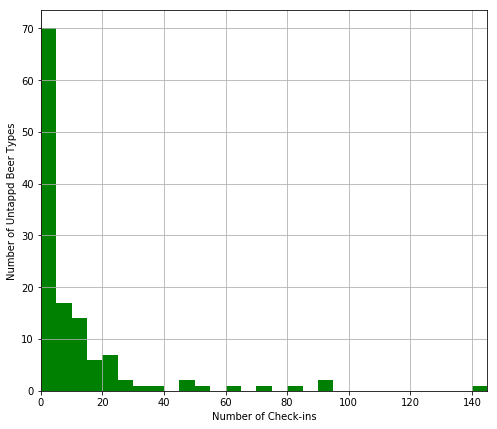

In [10]:
plt.figure(1, figsize=(8, 7))
beer_type_counts = untappd_ratingssyschanged.groupby('beer_type')['bid'].count()
bin_inc = 5
bins = bins=np.arange(0, beer_type_counts.max()+bin_inc, bin_inc)
plt.hist(beer_type_counts, bins=bins, color='g')
plt.xlabel('Number of Check-ins')
plt.ylabel('Number of Untappd Beer Types')
plt.xlim(0, bins.max())
plt.grid()
plt.show()

In [11]:
#Looking at the trends for all beer types with more than 30 check-ins

group = 'beer_type'
dep_var = 'rating_score'


anova_og_data = untappd_ratingssyschanged.dropna(subset=[dep_var])
anova_og_data = anova_og_data.groupby(group)
anova_og_data = anova_og_data.filter(lambda x: x[dep_var].count() > 30)
anova_og_data_grouped = anova_og_data.groupby(group)
anova_og_data_list = anova_og_data_grouped[dep_var].apply(list)

cat_df = pd.DataFrame(data = {'Count': anova_og_data_grouped['rating_score'].count(),
                              'Mean': anova_og_data_grouped['rating_score'].aggregate(np.mean),
                              'Median': anova_og_data_grouped['rating_score'].aggregate(np.median),
                              'Standard Deviation': anova_og_data_grouped['rating_score'].aggregate(np.std)})

cat_df.sort_values(by = ['Count'], inplace=True, ascending=False)

cat_df.style.bar(color='yellow')

,Count,Mean,Median,Standard Deviation
beer_type,,,,
IPA - American,138,4.04167,4,0.269467
IPA - Imperial / Double,94,4.2234,4.25,0.263016
Sour - Ale,93,4.30108,4.25,0.302972
Stout - American Imperial / Double,84,4.48214,4.5,0.326504
Saison / Farmhouse Ale,72,4.11458,4.25,0.391228
Stout - Imperial Milk / Sweet,63,4.54762,4.5,0.313851
American Wild Ale,53,4.35377,4.5,0.287705
Sour - Gose,48,4.18229,4.25,0.363712
Stout - Imperial / Double,46,4.40761,4.5,0.254726


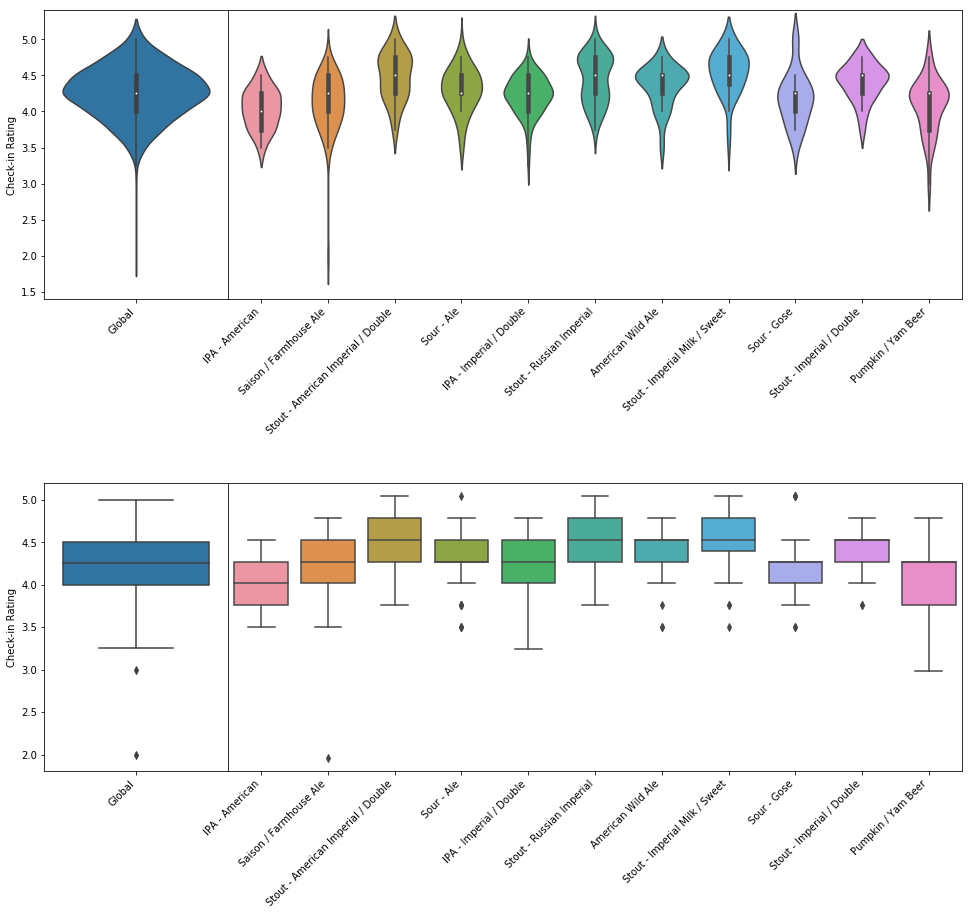

In [12]:
#Looking at the violin and box plots of the >30 size beer types


plt.figure(1, figsize=(15, 14))
gs = gridspec.GridSpec(5, 5)
gs.update(left=0.05, right=0.9, wspace=0)

#Make a viloin plot of total ratings distribution
plt.subplot(gs[:2, 0])
ax = sns.violinplot( y="rating_score", data=anova_og_data, bw=0.4)
ax.set_xticklabels(['Global'])
for label in ax.get_xmajorticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment("right")
plt.ylim(1.4, 5.4)
plt.ylabel('Check-in Rating')
plt.xlabel('')


#Make a violin plot
plt.subplot(gs[:2, 1:])
ax = sns.violinplot(x=group, y="rating_score", data=anova_og_data, bw=0.5)
plt.ylabel('')
plt.ylim(1.4, 5.4)
ax.set_yticks([])
for label in ax.get_xmajorticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment("right")
plt.xlabel('')

plt.subplot(gs[3:, 0])
ax = sns.boxplot(y="rating_score", data=anova_og_data)
for label in ax.get_xmajorticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment("right")
plt.xlabel('')
plt.ylabel('Check-in Rating')
plt.ylim(1.8, 5.2)
ax.set_xticklabels(['Global'])



plt.subplot(gs[3:, 1:])
ax = sns.boxplot(x=group, y="rating_score", data=anova_og_data)
for label in ax.get_xmajorticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment("right")
plt.xlabel('')
ax.set_yticks([])
plt.ylabel('')


plt.show()



In [13]:
#Check assumptions of the ANOVA - found all groups could be considered not normally distributed
for grouped_ratings in anova_og_data[dep_var].groupby(anova_og_data[group]):
    print(grouped_ratings[0])
    print(stats.shapiro(grouped_ratings[1]))


American Wild Ale
(0.8204925060272217, 1.5545804217254044e-06)
IPA - American
(0.9106957912445068, 1.5039829293073126e-07)
IPA - Imperial / Double
(0.878241777420044, 3.044221159598237e-07)
Pumpkin / Yam Beer
(0.8868294358253479, 0.002467983402311802)
Saison / Farmhouse Ale
(0.7970042824745178, 1.4261858360953283e-08)
Sour - Ale
(0.923043966293335, 3.8737529393984005e-05)
Sour - Gose
(0.9167666435241699, 0.0022908207029104233)
Stout - American Imperial / Double
(0.9126835465431213, 2.8807569833588786e-05)
Stout - Imperial / Double
(0.8704848289489746, 0.00010971647134283558)
Stout - Imperial Milk / Sweet
(0.8863050937652588, 2.890649739129003e-05)
Stout - Russian Imperial
(0.8723282217979431, 0.0007729975041002035)


In [15]:
#Running a kruskal-wallis test on these categories

s ,p = stats.kruskal(*anova_og_data_list, use_continuity=False)

print('Kruskal-Wallis Test Results')
print('statitic: ', s)
print('p: ', p)

Kruskal-Wallis Test Results
statitic:  187.27840822223672
p:  7.200761406362215e-35


In [16]:
#Run a Mann-Whitney for each category individually compared to the rest of the population

for this_beer_type in anova_og_data['beer_type'].unique():
    s,p = stats.mannwhitneyu(anova_og_data[anova_og_data['beer_type'] == this_beer_type]['rating_score'], anova_og_data[anova_og_data['beer_type'] != this_beer_type]['rating_score'])
    if p<0.05:
        print(this_beer_type, ': ', s, ', ', p)

IPA - American :  22502.0 ,  1.6911175348941292e-19
Saison / Farmhouse Ale :  18777.5 ,  0.00028086944683305466
Stout - American Imperial / Double :  17523.0 ,  2.33624292502648e-09
Stout - Russian Imperial :  9036.0 ,  0.0016353463750007026
American Wild Ale :  15190.0 ,  0.009546714586160864
Stout - Imperial Milk / Sweet :  10818.5 ,  4.149946860257219e-12
Sour - Gose :  13945.5 ,  0.014825096328454865
Stout - Imperial / Double :  11976.5 ,  0.0008271609297336793
Pumpkin / Yam Beer :  8617.5 ,  0.0025720001968605423


### Aggregating Untappd Categories

A lot of the Untappd categories looked like they could be aggregated.  I looked for an appropriate way to merge some of the styles and noticed several instances where there appeared to be a category and subcategory separated by a hyphen. For example, in this data set, there are three different types on Barleywine: Barleywine - American, Barleywine - English and Barleywine - Other. It turns out this is a common occurrence.  There are two Blonde Ales, 4 Bocks, 4 Brown Ales, 5 Ciders, 14 IPAs, 10 Lagers, 5 Lambics, 3 Pale Ales, 3 Pilsners, 5 Porters, 4 Red Ales, 7 Sours, 14 Stouts and 3 Strong Ales. So, I grouped check-ins into larger beer categories defined by the label preceding a hyphen (e.g., "Barleywine - American", "Barleywine - English" and "Barleywine - Other" all became "Barleywine." This new categorization scheme reduced the number of categories from 127 to 69.

The histogram shows the number of beer categories grouped by number of check-ins. While the vast majority of beer categories were still only sampled a handful of times, there are a few changes. If I again filter for only categories with greater than 30 check-ins, we are left with 9 categories. Some of these categories are much larger in size, with our largest group (Stout) consisting of 308 check-ins. While many of the categories are similar or derived from our most frequently drank Untappd beer types in the previous analysis (e.g., Stouts, IPA's), this dataset has a few new contenders are well (i,e., Porter, Pale Ale and Barleywine).

The violin and box plots show the distribution of the most frequently sampled beer categories.

I set out to see if there was a statistically significant relationship between the new beer categories and Colin's ratings. I again tested for an assumption to use the ANOVA: that all populations being compared must be normally distributed. So, I used the Shapiro-Wilk to test the null hypothesis that the group ratings are normally distributed. Unfortunately, using a 95% confidence level, we can reject the null hypothesis that any of the groups are normally distributed. Consequently, we will have to rely on non-parametric testing. The Kruskal-Wallis test shows that the medians of the categories do indeed differ from each other with statistical significance. I also looked at the Mann-Whitney U test between each of the beer categories and the rest of the population.


For 8 of the 9 beer categories,  the null hypothesis could be rejected! In other words, the distributions of ratings for the beer types differed from the global ratings with statistical significance for 8 of the 9 categories. The only category that seemed to not differentiate itself from the global ratings was the Sour beer.



In [17]:
#Grouping beer types by category
#Break the beer_type into two columns - category, subcategory, seperated by the hyphen
beer_type_split = untappd_all['beer_type'].str.split(' -', expand=True, n=1)

untappd_all['beer_category'] = beer_type_split[0]
untappd_all['beer_subcategory'] = beer_type_split[1]
untappd_ratingssyschanged['beer_category'] = beer_type_split[0]
untappd_ratingssyschanged['beer_subcategory'] = beer_type_split[1]

#How many types are there?
labels_cats, uniques_cats = pd.factorize(untappd_all['beer_category'])
print('Number of total different beer caetgories: ', uniques_cats.size)

Number of total different beer caetgories:  69


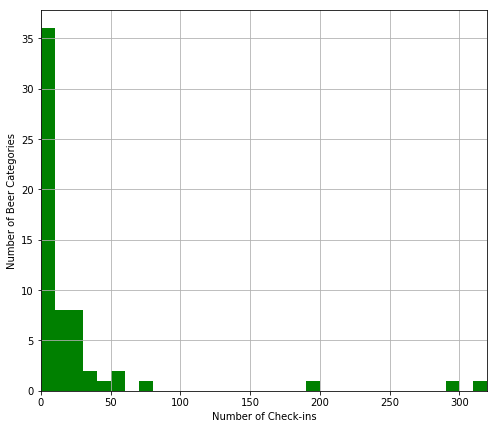

In [18]:
#Histogram of number of check-ins for each beer category

plt.figure(1, figsize=(8, 7))
beer_type_counts = untappd_ratingssyschanged.groupby('beer_category')['bid'].count()
bin_inc = 10
bins = bins=np.arange(0, beer_type_counts.max()+bin_inc, bin_inc)
plt.hist(beer_type_counts, bins=bins, color='g')
plt.xlabel('Number of Check-ins')
plt.ylabel('Number of Beer Categories')
plt.xlim(0, bins.max())
plt.grid()
plt.show()

In [22]:
#Look at the trends in the beer base categories
grouped = untappd_ratingssyschanged.groupby('beer_category')
cat_df = pd.DataFrame(data = {'Count': grouped['rating_score'].count(),
                              'Mean': grouped['rating_score'].aggregate(np.mean),
                              'Median': grouped['rating_score'].aggregate(np.median),
                              'Standard Deviation': grouped['rating_score'].aggregate(np.std)})

#Sort by mean score
cat_df.sort_values(by = ['Count'], inplace=True, ascending=False)

cat_df.style.bar(color='yellow')



,Count,Mean,Median,Standard Deviation
beer_category,,,,
Stout,308,4.41802,4.5,0.32968
IPA,293,4.10154,4,0.29792
Sour,193,4.25648,4.25,0.317086
Saison / Farmhouse Ale,72,4.11458,4.25,0.391228
Porter,54,4.07407,4,0.342127
American Wild Ale,53,4.35377,4.5,0.287705
Barleywine,48,4.34375,4.25,0.222564
Pumpkin / Yam Beer,33,4.08333,4.25,0.37326
Pale Ale,31,3.96774,4,0.300984


In [23]:
#Looking at the trends for beer base categories with more than 30 check-ins

untappd_type_subset_ratingssyschanged = untappd_ratingssyschanged.dropna(axis=0,subset=['rating_score']).groupby('beer_category')
untappd_type_subset_ratingssyschanged = untappd_type_subset_ratingssyschanged.filter(lambda x: len(x) > 30)

grouped = untappd_type_subset_ratingssyschanged.groupby('beer_category')
cat_df = pd.DataFrame(data = {'Count': grouped['rating_score'].count(),
                              'Mean': grouped['rating_score'].aggregate(np.mean),
                              'Median': grouped['rating_score'].aggregate(np.median),
                              'Standard Deviation': grouped['rating_score'].aggregate(np.std)})

#Sort by mean score
cat_df.sort_values(by = ['Count'], inplace=True, ascending=False)

cat_df.style.bar(color='yellow')

,Count,Mean,Median,Standard Deviation
beer_category,,,,
Stout,308,4.41802,4.5,0.32968
IPA,293,4.10154,4,0.29792
Sour,193,4.25648,4.25,0.317086
Saison / Farmhouse Ale,72,4.11458,4.25,0.391228
Porter,54,4.07407,4,0.342127
American Wild Ale,53,4.35377,4.5,0.287705
Barleywine,48,4.34375,4.25,0.222564
Pumpkin / Yam Beer,33,4.08333,4.25,0.37326
Pale Ale,31,3.96774,4,0.300984


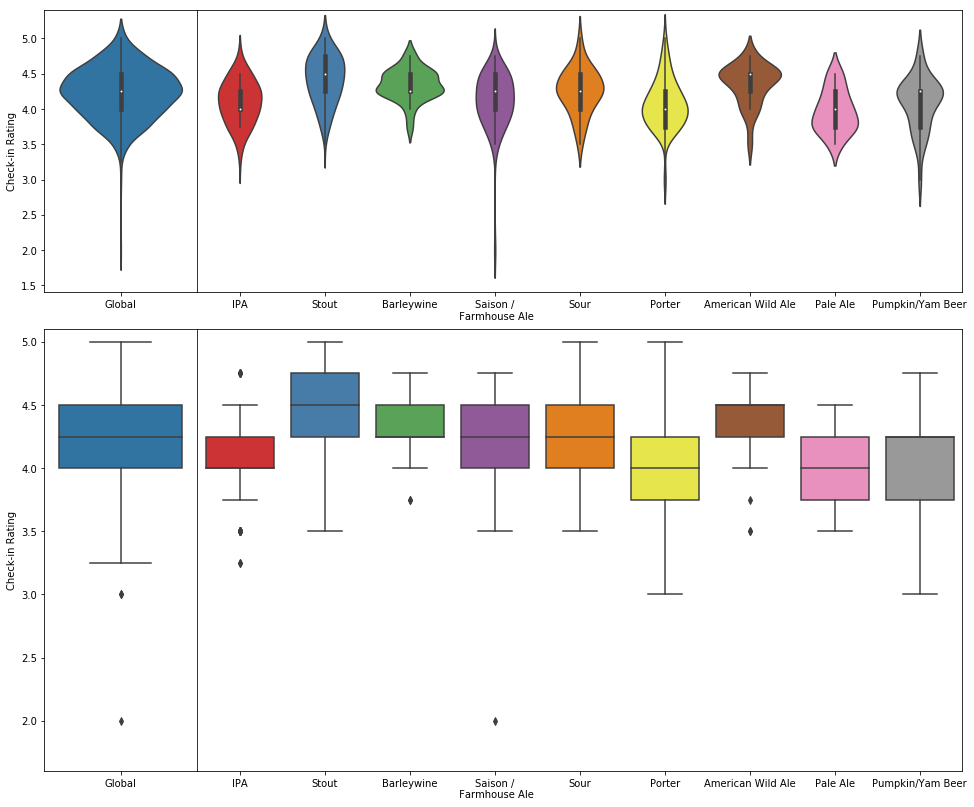

In [60]:
#Looking at the distribution of different beer base categories with check-ins >30

plt.figure(1, figsize=(15, 14))
gs = gridspec.GridSpec(5, 6)
gs.update(left=0.05, right=0.9, wspace=0, hspace=0.3)

#Make a viloin plot of total ratings distribution
plt.subplot(gs[:2, 0])
ax = sns.violinplot( y="rating_score", data=untappd_type_subset_ratingssyschanged, bw=0.4)
plt.ylabel('Check-in Rating')
ax.set_xticklabels(['Global'])
plt.xlabel('')
plt.ylim(1.4, 5.4)


#Make a violin plot
plt.subplot(gs[:2, 1:])
ax = sns.violinplot(x="beer_category", y="rating_score", data=untappd_type_subset_ratingssyschanged, bw=0.5, palette='Set1')
ax.set_xticklabels(['IPA', 'Stout', 'Barleywine', 'Saison /\n Farmhouse Ale', 'Sour', 'Porter', 'American Wild Ale', 'Pale Ale', 'Pumpkin/Yam Beer'])
ax.set_yticks([])
plt.ylabel('')
plt.xlabel('')
plt.ylim(1.4, 5.4)


plt.subplot(gs[2:, 0])
ax = sns.boxplot(y="rating_score", data=untappd_type_subset_ratingssyschanged)
plt.ylabel('Check-in Rating')
ax.set_xticklabels(['Global'])
plt.xlabel('')
plt.ylim(1.6, 5.1)


plt.subplot(gs[2:, 1:])
ax = sns.boxplot(x="beer_category", y="rating_score", data=untappd_type_subset_ratingssyschanged, palette='Set1')
ax.set_xticklabels(['IPA', 'Stout', 'Barleywine', 'Saison /\n Farmhouse Ale', 'Sour', 'Porter', 'American Wild Ale', 'Pale Ale', 'Pumpkin/Yam Beer'])
ax.set_yticks([])
plt.ylabel('')
plt.xlabel('')
plt.ylim(1.6, 5.1)


plt.show()

#The box plot is a little less interesting due to the discrete nature of the ratings data

In [61]:
#Check assumptions of the ANOVA - normality
data = untappd_type_subset_ratingssyschanged
group = 'beer_category'
dep_var = 'rating_score'
for grouped_ratings in data[dep_var].groupby(data[group]):
    print(grouped_ratings[0])
    print(stats.shapiro(grouped_ratings[1]))


American Wild Ale
(0.8204925060272217, 1.5545804217254044e-06)
Barleywine
(0.8651694655418396, 5.639144728775136e-05)
IPA
(0.9338069558143616, 3.736043419078072e-10)
Pale Ale
(0.8994020223617554, 0.006964766886085272)
Porter
(0.9047482013702393, 0.00041474433965049684)
Pumpkin / Yam Beer
(0.8868294358253479, 0.002467983402311802)
Saison / Farmhouse Ale
(0.7970042824745178, 1.4261858360953283e-08)
Sour
(0.9306013584136963, 5.888649567964421e-08)
Stout
(0.9264943599700928, 3.495321393431894e-11)


In [62]:
#Running a kruskal-wallis test on these categories

s ,p = stats.kruskal(*grouped['rating_score'].apply(list), use_continuity=False)

print('Kruskal-Wallis Test Results')
print('statitic: ', s)
print('p: ', p)

Kruskal-Wallis Test Results
statitic:  188.48903577315266
p:  1.692930970397326e-36


In [63]:
#Run a Mann-Whitney for each category individually compared to the rest of the population

for this_beer_type in data[group].unique():
    s,p = stats.mannwhitneyu(data[data[group] == this_beer_type][dep_var], data[data[group] != this_beer_type][dep_var])
    if p<0.05:
        print(this_beer_type, ': ', s, ', ', p)

IPA :  79432.0 ,  1.4322560087351151e-16
Stout :  71254.0 ,  8.480792180861197e-27
Barleywine :  20072.0 ,  0.01006865928066893
Saison / Farmhouse Ale :  29938.5 ,  0.004623422111047666
Porter :  19420.0 ,  6.143388893003377e-05
American Wild Ale :  20877.0 ,  0.0014474736937010906
Pale Ale :  8937.5 ,  5.242490160599885e-06
Pumpkin / Yam Beer :  13421.5 ,  0.01147303179400989


In [64]:
grouped_stouts = untappd_ratingssyschanged[untappd_ratingssyschanged['beer_category'] == 'Stout'].groupby('beer_subcategory')
stout_subcat_df = pd.DataFrame(data = {'Count': grouped_stouts['rating_score'].count(),
                              'Mean': grouped_stouts['rating_score'].aggregate(np.mean),
                                'Median': grouped_stouts['rating_score'].aggregate(np.median),
                              'Standard Deviations': grouped_stouts['rating_score'].aggregate(np.std)})

#Sort by mean score
stout_subcat_df.sort_values(by = ['Count'], inplace=True, ascending=False)

stout_subcat_df.style.bar(color='yellow')

,Count,Mean,Median,Standard Deviations
beer_subcategory,,,,
American Imperial / Double,84,4.48214,4.5,0.326504
Imperial Milk / Sweet,63,4.54762,4.5,0.313851
Imperial / Double,46,4.40761,4.5,0.254726
Russian Imperial,35,4.44286,4.5,0.327006
Milk / Sweet,16,4.17188,4.25,0.284587
Other,16,4.57812,4.5,0.176039
Oatmeal,15,4.05,4,0.193649
American,10,4.4,4.5,0.293447
Irish Dry,7,3.85714,3.75,0.133631


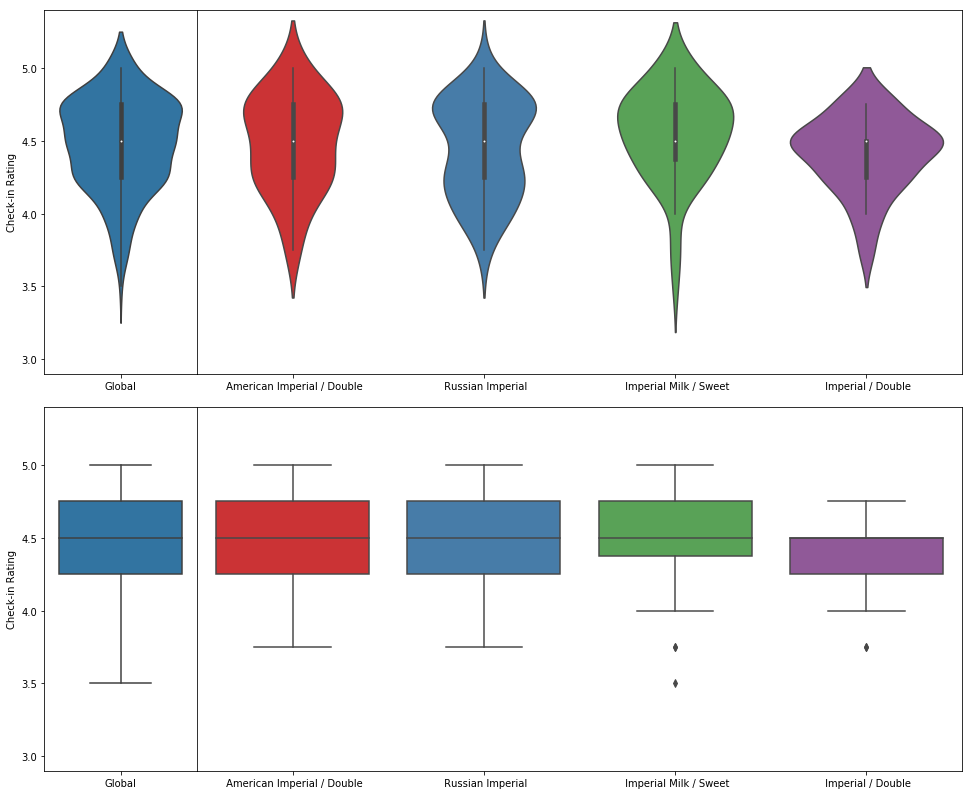

In [72]:
data = grouped_stouts
group= 'beer_subcategory'
dep_var = 'rating_score'

data = data.filter(lambda x: len(x) > 30)

#Looking at the distribution of different beer base categories with check-ins >30

plt.figure(1, figsize=(15, 14))
gs = gridspec.GridSpec(4, 6)
gs.update(left=0.05, right=0.9, wspace=0)

#Make a viloin plot of total ratings distribution
plt.subplot(gs[:2, 0])
ax = sns.violinplot( y=dep_var, data=data, bw=0.4)
plt.ylabel('Check-in Rating')
ax.set_xticklabels(['Global'])
plt.xlabel('')
plt.ylim(2.9, 5.4)


#Make a violin plot
plt.subplot(gs[:2, 1:])
ax = sns.violinplot(x=group, y=dep_var, data=data, bw=0.5, palette='Set1')
plt.ylabel('')
plt.xlabel('')
plt.ylim(2.9, 5.4)
ax.set_yticks([])


plt.subplot(gs[2:, 0])
ax = sns.boxplot(y=dep_var, data=data)
plt.ylabel('Check-in Rating')
ax.set_xticklabels(['Global'])
plt.xlabel('')
plt.ylim(2.9, 5.4)


plt.subplot(gs[2:, 1:])
ax = sns.boxplot(x=group, y=dep_var, data=data, palette='Set1')
plt.ylabel('')
plt.xlabel('')
plt.ylim(2.9, 5.4)
ax.set_yticks([])

plt.show()

#The box plot is a little less interesting due to the discrete nature of the ratings data

In [73]:
#Check assumptions of the ANOVA - normality

print(data.groupby(group)[dep_var])

for grouped_ratings in data.groupby(group)[dep_var]:
    print(grouped_ratings[0])
    print(stats.shapiro(grouped_ratings[1]))

 American Imperial / Double
(0.9126835465431213, 2.8807569833588786e-05)
 Imperial / Double
(0.8704848289489746, 0.00010971647134283558)
 Imperial Milk / Sweet
(0.8863050937652588, 2.890649739129003e-05)
 Russian Imperial
(0.8723282217979431, 0.0007729975041002035)


In [75]:
#Running a kruskal-wallis test on these categories

s ,p = stats.kruskal(*data.groupby(group)[dep_var].apply(list), use_continuity=False, nan_policy='omit')

print('Kruskal-Wallis Test Results')
print('statitic: ', s)
print('p: ', p)

Kruskal-Wallis Test Results
statitic:  7.290666023614785
p:  0.06318825870653139


In [77]:
grouped_ipas = untappd_ratingssyschanged[untappd_ratingssyschanged['beer_category'] == 'IPA'].groupby('beer_subcategory')
ipa_subcat_df = pd.DataFrame(data = {'Count': grouped_ipas['rating_score'].count(),
                              'Mean': grouped_ipas['rating_score'].aggregate(np.mean),
                              'Median': grouped_ipas['rating_score'].aggregate(np.median),
                              'Standard Deviation': grouped_ipas['rating_score'].aggregate(np.std)})

#Sort by mean score
ipa_subcat_df.sort_values(by = ['Count'], inplace=True, ascending=False)

ipa_subcat_df.style.bar(color='yellow')

,Count,Mean,Median,Standard Deviation
beer_subcategory,,,,
American,138,4.04167,4,0.269467
Imperial / Double,94,4.2234,4.25,0.263016
Belgian,14,3.92857,4,0.117202
Session / India Session Ale,11,3.86364,3.75,0.171888
Triple,10,4.5,4.5,0.311805
New England,9,4.25,4.25,0.176777
Black / Cascadian Dark Ale,3,3.83333,3.75,0.144338
English,3,3.5,3.5,0.25
Imperial / Double New England,3,4.33333,4.5,0.288675


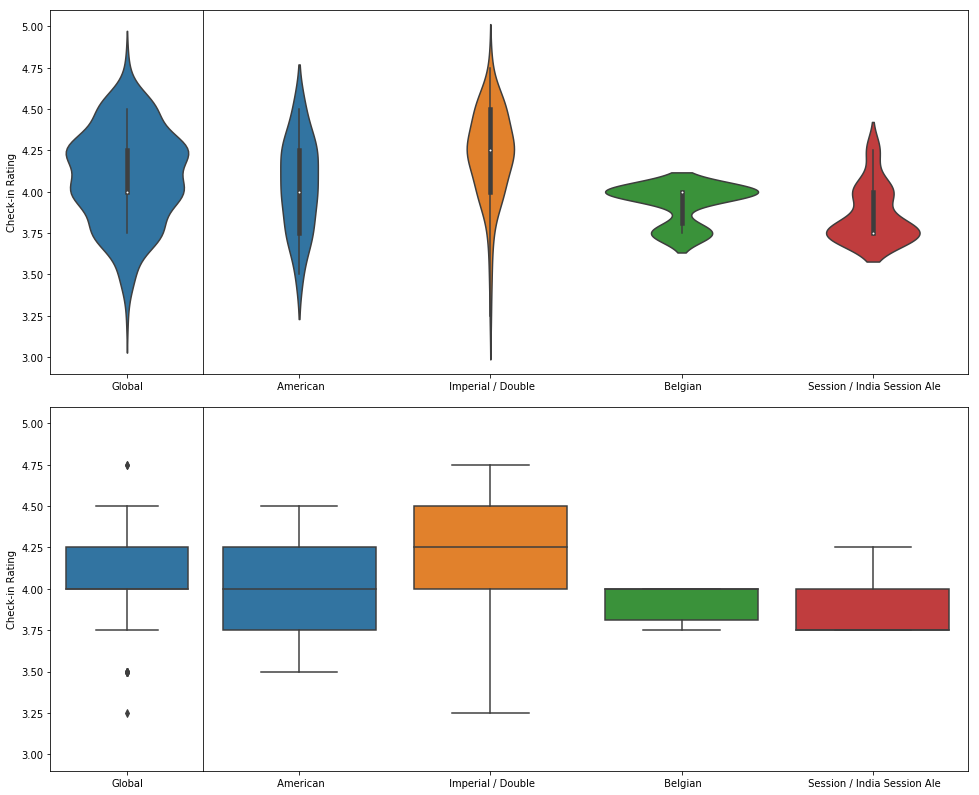

In [84]:
data = grouped_ipas
group= 'beer_subcategory'
dep_var = 'rating_score'

data = data.filter(lambda x: len(x) > 10)
data.dropna(subset=[dep_var], inplace=True)

#Looking at the distribution of different beer base categories with check-ins >30

plt.figure(1, figsize=(15, 14))
gs = gridspec.GridSpec(4, 6)
gs.update(left=0.05, right=0.9, wspace=0)

#Make a viloin plot of total ratings distribution
plt.subplot(gs[:2, 0])
ax = sns.violinplot( y=dep_var, data=data, bw=0.4)
plt.ylabel('Check-in Rating')
ax.set_xticklabels(['Global'])
plt.xlabel('')
plt.ylim(2.9, 5.1)

#Make a violin plot
plt.subplot(gs[:2, 1:])
ax = sns.violinplot(x=group, y=dep_var, data=data, bw=0.5)
plt.ylabel('')
plt.xlabel('')
plt.ylim(2.9, 5.1)
ax.set_yticks([])

plt.subplot(gs[2:, 0])
ax = sns.boxplot(y=dep_var, data=data)
plt.ylabel('Check-in Rating')
ax.set_xticklabels(['Global'])
plt.xlabel('')
plt.ylim(2.9, 5.1)

plt.subplot(gs[2:, 1:])
ax = sns.boxplot(x=group, y=dep_var, data=data)
plt.ylabel('')
plt.xlabel('')
plt.ylim(2.9, 5.1)
ax.set_yticks([])

plt.show()

#The box plot is a little less interesting due to the discrete nature of the ratings data

In [85]:
#Check assumptions of the ANOVA - normality

for grouped_ratings in data.groupby(group)[dep_var]:
    print(grouped_ratings[0])
    print(stats.shapiro(grouped_ratings[1]))

 American
(0.9106957912445068, 1.5039829293073126e-07)
 Belgian
(0.5760508179664612, 2.5007562726386823e-05)
 Imperial / Double
(0.878241777420044, 3.044221159598237e-07)
 Session / India Session Ale
(0.7013553380966187, 0.0004869135736953467)


In [90]:
#Running a kruskal-wallis test on these categories
print(data.groupby(group)[dep_var].apply(list))

s ,p = stats.kruskal(*data.groupby(group)[dep_var].apply(list), use_continuity=False, nan_policy='omit')

print('Kruskal-Wallis Test Results')
print('statitic: ', s)
print('p: ', p)

beer_subcategory
 American                       [3.75, 3.75, 3.75, 3.75, 3.75, 3.75, 4.0, 4.0,...
 Belgian                        [3.75, 3.75, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 3.7...
 Imperial / Double              [4.25, 3.25, 4.5, 4.0, 4.25, 3.5, 4.0, 4.25, 4...
 Session / India Session Ale    [3.75, 3.75, 3.75, 3.75, 4.0, 4.0, 3.75, 4.25,...
Name: rating_score, dtype: object
Kruskal-Wallis Test Results
statitic:  42.992329185216704
p:  2.4702482554942413e-09


In [100]:
#Just check American vs. Imperial Double

#Run a Mann-Whitney for each category individually compared to the rest of the population

s,p = stats.mannwhitneyu(data[data['beer_subcategory'] == ' American'][dep_var], data[data['beer_subcategory'] == ' Imperial / Double'][dep_var])

print( s, ', ', p)


4049.0 ,  2.3386709732029836e-07


### Ale vs. Lager

While there appears to be very little in the way of a standard beer categorization scheme, one overarching categorization seem to hold mostly true: ale vs. lager. The difference between ales and lagers is where the yeast ferments the beer. In ales, yeast ferments at warmer temperatures and ferment near the surface. The yeast in lagers, on the other hand, ferments at lower temperatures and tends to collect at the bottom. So, for the final categorization of beer types, I decided to look at the differences in this data set between lagers and ales.

Unfortunately, the Untappd dataset wasn't sorted between ales vs. lagers, so I had to do it manually.

